In [35]:
import sys
sys.path.append("../")
import numpy as np
import matplotlib.pyplot as plt

from database import models as dm
from sqlalchemy import select, create_engine
from sqlalchemy.orm import Session
from database.env import DATABASE_URI

engine = create_engine(DATABASE_URI)

from importlib import reload

reload(dm)

<module 'database.models' from '/home/hayden/repos/module_pcb_thermal_mockup/analysis/../database/models.py'>

In [41]:
TM1_minus_20 = """
Probe 1: 0xf6b3
Probe 2: 0xf6d3
Probe 3: 0xf6db
""" #approx -18.3 for all so off by 1.7 degrees too warm

def convert_hex(hex:str):
    int_value = int(hex, 16)
    int_value >>= 3
    if int_value & 0x1000:
        int_value -= 0x2000
    return int_value * 0.0625

for probe_temp in TM1_minus_20.split("\n"):
    if probe_temp:
        probe, hex_temp = probe_temp.split(":")

        probe_temp = convert_hex(hex_temp.strip())
        
        print(f"{probe.strip()} is {probe_temp} degrees C")

        print(f"Difference: {-20.2 - probe_temp}")
# see if TM2 is constant offset throughout then if so just do 2 deg offset

Probe 1 is -18.625 degrees C
Difference: -1.5749999999999993
Probe 2 is -18.375 degrees C
Difference: -1.8249999999999993
Probe 3 is -18.3125 degrees C
Difference: -1.8874999999999993


0.9993412960147778 2.1502590885314525
{'E1': SensorCalibration(id=15, module_id=4, sensor='E1', slope=3.0785784177814293, intercept=730.9766634890818), 'E2': SensorCalibration(id=16, module_id=4, sensor='E2', slope=3.0506182050327175, intercept=725.9377043808703), 'E3': SensorCalibration(id=17, module_id=4, sensor='E3', slope=3.4360412807938956, intercept=815.3262214615588), 'E4': SensorCalibration(id=18, module_id=4, sensor='E4', slope=3.126831719874252, intercept=741.57580651833), 'L1': SensorCalibration(id=19, module_id=4, sensor='L1', slope=3.467637848345944, intercept=825.0850209915361), 'L2': SensorCalibration(id=20, module_id=4, sensor='L2', slope=3.9223216899902753, intercept=929.0959531344205), 'L3': SensorCalibration(id=21, module_id=4, sensor='L3', slope=3.5288622261445455, intercept=836.5884801416535), 'L4': SensorCalibration(id=22, module_id=4, sensor='L4', slope=3.494560769434381, intercept=828.9906787375295), 'P1': SensorCalibration(id=23, module_id=4, sensor='P1', slope

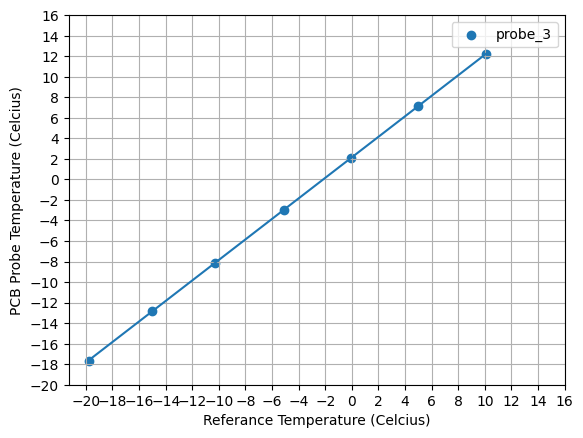

In [ ]:
def plot_fit(data:list[tuple], **kwargs) -> tuple[float, float]:
    x = np.array([d[0] for d in data])
    y = np.array([d[1] for d in data])

    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b, **kwargs)
    return m, b


TM2_probe_calibration = {
    10.1: "Probe 1: 0x5e3, Probe 2: 0x623, Probe 3: 0x61b",
    5: "Probe 1: 0x35b, Probe 2: 0x39b, Probe 3: 0x39b",
    -0.1: "Probe 1: 0xcb, Probe 2: 0x10b, Probe 3: 0x10b",
    -5.1:"Probe 1: 0xfe4b, Probe 2: 0xfe8b, Probe 3: 0xfe8b",
    -10.3: "Probe 1: 0xfbbb, Probe 2: 0xfbfb, Probe 3: 0xfbf3",
    -15: "Probe 1: 0xf95b, Probe 2: 0xf99b, Probe 3: 0xf99b",
    -19.8: "Probe 1: 0xf6f3, Probe 2: 0xf733, Probe 3: 0xf72b"
}

# print the actual temp and the probe temp
probe_1 = []
probe_2 = []
probe_3 = []
for actual_temp, raw_probe_temps in TM2_probe_calibration.items():
    probes = ["Probe 1", "Probe 2", "Probe 3"]
    probe_temps = [convert_hex(pt.split()[-1]) for pt in raw_probe_temps.split(', ')]
    probe_1.append((actual_temp, probe_temps[0]))
    probe_2.append((actual_temp, probe_temps[1]))
    probe_3.append((actual_temp, probe_temps[2]))


plt.scatter(*zip(*probe_3), label="probe_3")
m, b = plot_fit(probe_3)
print(m, b)

# with Session(engine) as session:
#     module_name = "TM2"
#     module = session.execute(
#         select(dm.Module).where(dm.Module.name==module_name)).scalar_one_or_none()

#     sensor_cal = dm.SensorCalibration(
#         module = module,
#         sensor = "P3",
#         slope = m.item(),
#         intercept = b.item()
#     )

#     session.add(sensor_cal)

#     module.calibration.P3 = sensor_cal

#     session.commit()

#     print(module.calib_map())

# plt.scatter(*zip(*probe_2), label="probe 2")
# plt.scatter(*zip(*probe_3), label="probe 3")

plt.xticks(range(-20, 15+2, 2))
plt.yticks(range(-20, 15+2, 2))

plt.xlabel("Referance Temperature (Celcius)")
plt.ylabel("PCB Probe Temperature (Celcius)")
plt.grid()
plt.legend()

In [42]:
with Session(engine) as session:
    module_name = "TM1"
    module = session.execute(
        select(dm.Module).where(dm.Module.name==module_name)).scalar_one_or_none()

    P1_calib = dm.SensorCalibration(
        module = module,
        sensor = "P1",
        slope = 1,
        intercept = 1.57
    )

    P2_calib = dm.SensorCalibration(
        module = module,
        sensor = "P1",
        slope = 1,
        intercept = 1.825
    )

    P3_calib = dm.SensorCalibration(
        module = module,
        sensor = "P1",
        slope = 1,
        intercept = 1.887
    )

    session.add(P1_calib)
    session.add(P2_calib)
    session.add(P3_calib)

    module.calibration.P1 = P1_calib
    module.calibration.P2 = P2_calib
    module.calibration.P3 = P3_calib

    session.commit()
    print(module.calib_map())

{'E1': SensorCalibration(id=9, module_id=3, sensor='E1', slope=3.0454073169094427, intercept=720.3620148714372), 'E2': SensorCalibration(id=10, module_id=3, sensor='E2', slope=3.0164925016904887, intercept=713.1815843621783), 'E3': SensorCalibration(id=11, module_id=3, sensor='E3', slope=3.123204620961759, intercept=734.3684688591846), 'E4': SensorCalibration(id=12, module_id=3, sensor='E4', slope=3.150819893504239, intercept=742.5311538628704), 'L1': SensorCalibration(id=13, module_id=3, sensor='L1', slope=3.751999862782604, intercept=884.4843530694752), 'L2': None, 'L3': SensorCalibration(id=14, module_id=3, sensor='L3', slope=3.5789222776396072, intercept=841.3767455599545), 'L4': None, 'P1': SensorCalibration(id=26, module_id=3, sensor='P1', slope=1.0, intercept=1.57), 'P2': SensorCalibration(id=27, module_id=3, sensor='P1', slope=1.0, intercept=1.825), 'P3': SensorCalibration(id=28, module_id=3, sensor='P1', slope=1.0, intercept=1.887)}
